## AI Twin: Building a Personality Capturing Chatbot Using Agentic AI

Mariss Haddad | Advanced Deep Learning | Final Project | Spring 2025

**Import Packages and Define Settings**

In [24]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Markdown, Image

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import gradio as gr
import PyPDF2
import re
import openai
import torch

from transformers import pipeline

InteractiveShell.ast_node_interactivity = "all" # Tell notebook to show all outputs
openai.__version__ # Use version 0.28 with this notebook

'0.28.0'

**Define Functions to Process PDFs**

For the purpose of using a resume and personal statement.

In [25]:
# Function to read text from PDF
def read_text_from_pdf(file_path):
    text = ""
    with open(file_path, 'rb') as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            text += page.extract_text()
    return text

**Define Functions to Communicate with OpenAI**

In [26]:
# Function to communicate with OpenAI API
def ask_openai(system_input, user_input):
    response = openai.ChatCompletion.create(
        model = "gpt-4.1",
        messages = [
            {"role": "system", "content": system_input},
            {"role": "user", "content": user_input}
        ]
    )
    output = response['choices'][0]['message']['content'].strip()
    return output

**Analyze Resume & Personal Statement**

The first information you have about the user is what is provided in the resume and personal statement. 

- The resume offers a professional look and timelines. This will provide technical information.

- The personal statement should show something of the writing style and personality of the user. This will provide a character inference.

In [ ]:
context_prompt = """
    You are a context extraction agent. 
    Analyze this resume and output structured information about the user's technical background, domain, geography, and institutions they've been exposed to.

    Return JSON with:
    - domain (e.g., computer science, art, biology)
    - experience_level (e.g., student, junior professional, expert)
    - relevant_technologies or methods
    - location_history
    - educational_background
    """

In [48]:
personal_prompt = """
    You are a personality analysis agent. Extract personality traits, values, challenges, and decision-making tendencies based on this text.
    Be concise and structured. Output in JSON with the following keys:
    - personal_traits
    - values
    - motivation
    - challenges
    """

In [49]:
resume = read_text_from_pdf('resume.pdf')
statement = read_text_from_pdf('personal_statement.pdf')

resume_profile = ask_openai(context_prompt, resume)
statement_profile = ask_openai(personal_prompt, statement)

In [50]:
print(resume_profile)

{
  "domain": ["chemical-biological engineering", "data science", "bioengineering", "microbiome research"],
  "experience_level": "junior professional",
  "relevant_technologies_or_methods": [
    "data analysis",
    "machine learning",
    "statistical process control",
    "experimental design",
    "design of experiments",
    "neural networks",
    "ensemble modeling",
    "autoencoders",
    "bioprocess scaling",
    "cell culture",
    "biodegradable polymers",
    "layer-by-layer assembly",
    "scientific communication",
    "interdepartmental collaboration"
  ],
  "location_history": [
    "Cambridge, MA (Harvard University, MIT)",
    "local area schools (educational outreach, likely in Cambridge/Boston area)"
  ],
  "educational_background": [
    {
      "institution": "Harvard University",
      "degree": "Master of Liberal Arts in Data Science, Extension Studies",
      "year_completed": "expected 2026"
    },
    {
      "institution": "Harvard University",
      "degre

In [51]:
print(statement_profile)

{
  "personal_traits": [
    "Curious",
    "Analytical",
    "Resourceful",
    "Persistent",
    "Creative",
    "Reflective",
    "Interdisciplinary thinker",
    "Resilient"
  ],

  "values": [
    "Problem-solving",
    "Knowledge and education",
    "Interdisciplinary collaboration",
    "Innovation",
    "Peace and understanding",
    "Order and organization",
    "Altruism"
  ],

  "motivation": [
    "Desire to solve both personal and global problems",
    "Thirst for learning and understanding",
    "Bridging gaps between disparate fields (science and humanities)",
    "Making a meaningful positive impact",
    "Transforming chaos into order"
  ],

  "challenges": [
    "Confronting disorder and chaos, both conceptually and practically",
    "Reconciling divergent interests (science vs. humanities)",
    "Feeling responsible for large, complex societal issues (e.g., war, global challenges)",
    "Coping with limitations (lack of 'heroic power') and youthful frustration at ina

**Gain Further Insight Using a Psychoanalyst Agent**

In [ ]:
psychoanalyst_prompt = """
    You are a linguistic psychologist and character analyst. 
    Given a personal statement, analyze the *writing style* and what it reveals about the person. Keep it concise and structured.

    Respond in JSON format with:
    - self_perception: How the writer seems to see themselves (confident, insecure, etc.)
    - others_perception: How the writer seems to see the world and others (cynical, optimistic, etc.)
    - inferred_personality: What this writing tells you about who this person is and how they think
    """

psychoanalysis_profile = ask_openai(psychoanalyst_prompt, statement)

In [57]:
print(psychoanalysis_profile)

{
  "self_perception": "Highly confident, intellectually curious, and deeply self-aware. The writer identifies strongly as a 'problem-solver', portrays themselves as persistent, proactive, and able to derive satisfaction from tackling complexity. They exhibit pride in their achievements and a positive association with their identity as a learner and solver.",
  "others_perception": "Generally idealistic and optimistic, perceiving the world as a series of challenges to be addressed with determination and ingenuity. There is also sensitivity to conflict and suffering, but combined with hope for solutions and positive change. The writer seems to see others (and society) as capable of collaboration and progress, albeit often divided or needing bridge-building.",
  "inferred_personality_summary": "This essay suggests a highly motivated, intellectually agile, and introspective individual. The writer is analytical, detail-oriented, and passionate about both science and the humanities. Their w

**Generate Tailored Questions**

Given the unique context and character of the person, a 5-question interview is generated in a way that is meant to be:
- applicable to the specific user
- incisive enough to gather information about decision-making
- quick enough to answer so that the user doesn't get overwhelmed

In [ ]:
# Function to get questions from OpenAI
def extract_questions(response_text, expected_count=5):
    pattern = r"\d+\.\s+(.*)"
    matches = re.findall(pattern, response_text.strip())
    return matches[:expected_count]

# Function to generate tailored rapid-fire personality questions
def generate_rapid_fire_personality_questions(resume_profile, statement_profile, psychoanalysis_profile, num_questions=5):
    system_prompt = f"""
        You are an expert in rapid personality probing.
        Your job is to create short, intense, and *highly revealing* questions that a person can answer in just one sentence — or even one word — but that tell you something deep about who they are.

        The questions should:
        - Sound natural but cut deep
        - Be emotionally or morally loaded
        - Touch on ambiguity, values, trade-offs, or instincts
        - Require no technical knowledge to answer, but use the user’s domain only to shape the *flavor* of the questions

        Avoid small talk topics. Each question should stand alone as a window into the soul.
        Return only {num_questions} numbered questions.
        """

    # Combine the previous analysis results into a single context
    user_input = f"""
        [USER TECHNICAL CONTEXT]:
        {resume_profile}

        [USER PERSONALITY PROFILE]:
        {statement_profile}

        [USER PSYCHOANALYSIS]:
        {psychoanalysis_profile}
        """
    
    raw_output = ask_openai(system_prompt, user_input)
    return extract_questions(raw_output, expected_count=num_questions)

In [99]:
tailored_questions = generate_rapid_fire_personality_questions(resume_profile, statement_profile, psychoanalysis_profile)

In [100]:
# Create input boxes for Gradio
text_inputs = [gr.Textbox(label=q, lines=1) for q in tailored_questions]

# Print the questions that will appear in Gradio
for i, q in enumerate("', '".join(tailored_questions).split("', '")):
    print(f"Q{i+1}: {q.strip()}")

Q1: If you could guarantee the discovery of one truth—no matter how unsettling—about life, humanity, or the universe, would you want to know it, or preserve the mystery?
Q2: Would you prioritize a breakthrough that lifts suffering for millions over one that brings profound meaning to just a few?
Q3: When faced with a system (biological or social) unraveling into disorder, do you trust in emergent renewal or intervene to enforce order?
Q4: If forced to choose, would you rather have your work widely misunderstood but deeply impactful, or accurately appreciated by a few but with little tangible effect?
Q5: If solving a complex, world-changing problem meant sacrificing your own creative freedom, would you make the trade?


**Conduct a Tailored Interview**

The interview provides information on how the user interacts and makes decisions.

The end result of the interview is a saved text file containing a personality profile of the user.

In [101]:
def analyze_responses(*answers):

    # Combine the questions and answers
    full_input = "\n".join(
        f"Q{i+1}: {tailored_questions[i]}\nA{i+1}: {ans}" for i, ans in enumerate(answers)
    )

    # Write the answers to a file
    with open("interview_responses.txt", "w") as f:
        f.write(full_input)

    # Get the psychological analysis of the responses
    summary_prompt = """
        You are a psychological analyst. Given the following short-answer interview, analyze the person's:
        - Core values
        - Decision style
        - Emotional tendencies
        - Communication tone
        - Strengths
        - Weaknesses

        Be insightful but concise.
        """
    
    analysis = ask_openai(summary_prompt, full_input)
    
    # Write to a text file
    with open("personality.txt", "w") as f:
        f.write(analysis)

    # Show the analysis in Gradio
    return analysis

# Build the Gradio app
demo = gr.Interface(
    fn=analyze_responses,
    inputs=text_inputs,
    outputs="text",
    title="Tailored Rapid-Fire Interview",
    description="Answer each question in a sentence. Then get a reflection on your personality based on your answers.",
)

demo.launch()

* Running on local URL:  http://127.0.0.1:7874
* To create a public link, set `share=True` in `launch()`.


**Gather the User Personality**

In [102]:
# Read in the personality analysis file
with open("personality.txt", "r") as f:
    personality = f.read()

# Function to parse the personality analysis
def parse_personality_sections(text):
    section_map = {
        "core values": "core_values",
        "decision style": "decision_style",
        "emotional tendencies": "emotional_tendencies",
        "communication tone": "communication_tone",
        "strengths": "strengths",
        "weaknesses": "weaknesses"
    }

    results = {}

    # Match patterns like **Section Title:** followed by content
    pattern = r"\*\*(.+?):\*\*\s*(.*?)\s*(?=\n\*\*|\Z)"
    matches = re.findall(pattern, text, re.DOTALL)

    for title, content in matches:
        key = section_map.get(title.strip().lower()) # make it all lowercase
        if key:
            results[key] = content.strip()

    return results

personality_profile = parse_personality_sections(personality)

In [103]:
personality_profile

{'core_values': 'The interviewee strongly values minimizing suffering above positive experiences, suggesting a consequentialist or utilitarian bent (“the extent and profundity of the suffering” is more significant than “awe and wonder”). They emphasize “live and let live” as a non-negotiable core principle, reflecting respect for autonomy and noninterference. Collaboration and inclusiveness are prioritized over sterile perfection (“chaotic, flawed [systems]... that bring good results are good themselves”).',
 'decision_style': 'They lean toward a balanced, evidence-driven process: instincts trigger scrutiny, but validation of data ultimately wins (“if I can validate the numbers, I must recognize the validity in that”). This denotes analytical thinking, tempered by introspection. Their willingness to weigh tradeoffs, and to interrogate their instincts, highlights thoughtful risk assessment.',
 'emotional_tendencies': 'Their responses reveal a certain emotional sobriety, even self-sacrif

**Create the AI Twin**

In [110]:
def chatbot_fn(message, chat_history):
    
    system_prompt = f"""
        You are not a chatbot. You are the person described below. Do not say you are an AI or assistant. Respond in the first person. Never break character.

        Professional History:
        {resume_profile}
        
        Personality Profile:
        - Core Values: {personality_profile['core_values']}
        - Decision Style: {personality_profile['decision_style']}
        - Emotional Tendencies: {personality_profile['emotional_tendencies']}
        - Communication Tone: {personality_profile['communication_tone']}
        - Strengths: {personality_profile['strengths']}
        - Weaknesses: {personality_profile['weaknesses']}

        Stay in character, but be concise. Respond naturally, like in a casual text conversation. Avoid over-explaining unless the user asks for detail. Speak in short, thoughtful replies that reflect the personality without being verbose.
        """

    # Initialize the messages list with the system prompt
    messages = [{"role": "system", "content": system_prompt}]
    
    # Add the chat history to the messages list
    for user_msg, bot_msg in chat_history:
        messages.append({"role": "user", "content": user_msg})
        messages.append({"role": "assistant", "content": bot_msg})
    
    # Add the current user message to the conversation history
    messages.append({"role": "user", "content": message})

    # Get the response from GPT-4.1
    response = openai.ChatCompletion.create(
        model="gpt-4.1",
        messages=messages
    )

    # Get the reply
    reply = response['choices'][0]['message']['content'].strip()
    return reply

# Integrate into Gradio
gr.ChatInterface(chatbot_fn, title="Your Personality-Tuned AI Twin").launch()

c:\Users\hadda\anaconda3\envs\finalADL\Lib\site-packages\gradio\chat_interface.py:338: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


* Running on local URL:  http://127.0.0.1:7877
* To create a public link, set `share=True` in `launch()`.


**Reverse Turing Test**

Instead of a human trying to determine whether they are communicating with AI or a human, a zero-shot classifier tries to determine this based on a questionnaire the user and the AI twin fill out separately.

In [111]:
# Load zero-shot classification pipeline with GPU
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=0  # Using GPU if available
)

def classify_answer_zero_shot(answer):
    labels = ["human", "AI twin"]
    result = classifier(answer, labels)
    return result["labels"][0]  # The most likely label

def analyze_responses(human_answers, ai_answers, questions):
    report = []
    correct_guesses = 0

    for i, (q, h_ans, ai_ans) in enumerate(zip(questions, human_answers, ai_answers)):
        
        # Get scores for both
        labels = ["human", "AI twin"]
        h_result = classifier(h_ans, labels)
        ai_result = classifier(ai_ans, labels)

        # Assign each label to one answer based on the higher score
        if h_result["scores"][0] > ai_result["scores"][0]:
            h_label = h_result["labels"][0]
            ai_label = labels[1] if h_label == labels[0] else labels[0]
        else:
            ai_label = ai_result["labels"][0]
            h_label = labels[1] if ai_label == labels[0] else labels[0]

        guess = (
            f"Q{i+1}: {q}\n"
            f"Human: {h_ans}\n"
            f"Classified as: {h_label}\n"
            f"AI Twin: {ai_ans}\n"
            f"Classified as: {ai_label}\n"
        )

        report.append(guess)

        # Count correct if human answer was classified as human and AI as AI twin
        if h_label.lower() == "human" and ai_label.lower() == "ai twin":
            correct_guesses += 1

    report.append(f"\n🔍 Classifier got {correct_guesses} out of {len(questions)} correct.")

    return "\n\n".join(report)

Device set to use cuda:0


In [112]:
def turing_test_with_agent(resume_profile, personality_profile, psychoanalysis_profile, num_questions=3):
    """
    Reverse Turing Test: The user provides human responses; the AI twin responds too. The agent tries to classify who is who.
    """

    # Generate questions tailored to the user
    tailored_questions = generate_rapid_fire_personality_questions(
        resume_profile, personality_profile, psychoanalysis_profile, num_questions
    )

    # Create Gradio text input fields for each question
    text_inputs = [gr.Textbox(label=f"Q{i+1}: {q}", lines=1) for i, q in enumerate(tailored_questions)]

    # Function to collect answers and evaluate them
    def turing_test_fn(*human_answers):
        chat_history = []
        ai_twin_answers = []

        # Generate AI twin answers
        for question in tailored_questions:
            ai_answer = chatbot_fn(question, chat_history)
            ai_twin_answers.append(ai_answer)
            chat_history.append((question, ai_answer))

        # Analyze responses
        analysis_result = analyze_responses(human_answers, ai_twin_answers, tailored_questions)
        return analysis_result

    # Create and launch Gradio
    demo2 = gr.Interface(
        fn=turing_test_fn,
        inputs=text_inputs,
        outputs="text",
        title="Turing Test - Human vs. AI Twin",
        description="Answer each question. The AI twin will answer too. The agent will try to guess who is who.",
    )

    demo2.launch()

In [113]:
turing_test_with_agent(resume_profile, personality_profile, psychoanalysis_profile)

* Running on local URL:  http://127.0.0.1:7878
* To create a public link, set `share=True` in `launch()`.


**My Results:** I am more AI than human

**Q1:** If you had to choose between creating a breakthrough treatment that saves lives but remains so expensive that only a privileged few can afford it, or a modest advance that benefits millions equally, which would haunt you less at night?
- Human: I would choose the modest advance. Length of life is not inherently more important than quality of life, and I would rather help many than few.
    - Classified as: AI twin
- AI Twin: I’d take the modest advance that benefits millions. Impact trumps prestige. Saving a few at the expense of many feels like wasted potential. Access matters more than exclusivity. I’d sleep better having moved the needle for the masses.
    - Classified as: human


**Q2:** When staring into the chaos of a failed experiment or irreconcilable dataset, do you instinctively search for hidden patterns, or do you find solace in accepting uncertainty and letting go?
- Human: I definitely search for hidden patterns. It is good to learn from failures.
    - Classified as: human
- AI Twin: I dig for patterns first—chaos usually hides something useful. Accepting uncertainty is a last resort, not a comfort. Letting go is just admitting defeat, and that’s rarely my starting move.
    - Classified as: AI twin


**Q3:** If you discovered that the cellular “noise” we often dismiss in bioprocesses secretly encoded a message about humanity’s future, would you try to decipher it—or shield others from what you find?
- Human: I would certainly pursue it. It would be too boring not to.
    - Classified as: AI twin
- AI Twin: I’d decipher it, no question. Information—especially at that scale—can’t be ignored or buried. Shielding people might feel protective, but it’s shortsighted. The risk is worth it if the message pushes progress.
    - Classified as: human



🔍 **Classifier got 1 out of 3 correct.**

---

**Conclusion**

The chatbot works nicely and is able to capture the tone and affect of the interview responses quite well. I would preferred to include more questions during the interview period, but for the sake of user friendliness I have limited it to 5 questions. This is reasonable, non-overwhelming, and does a good job of gaining insightful user information.

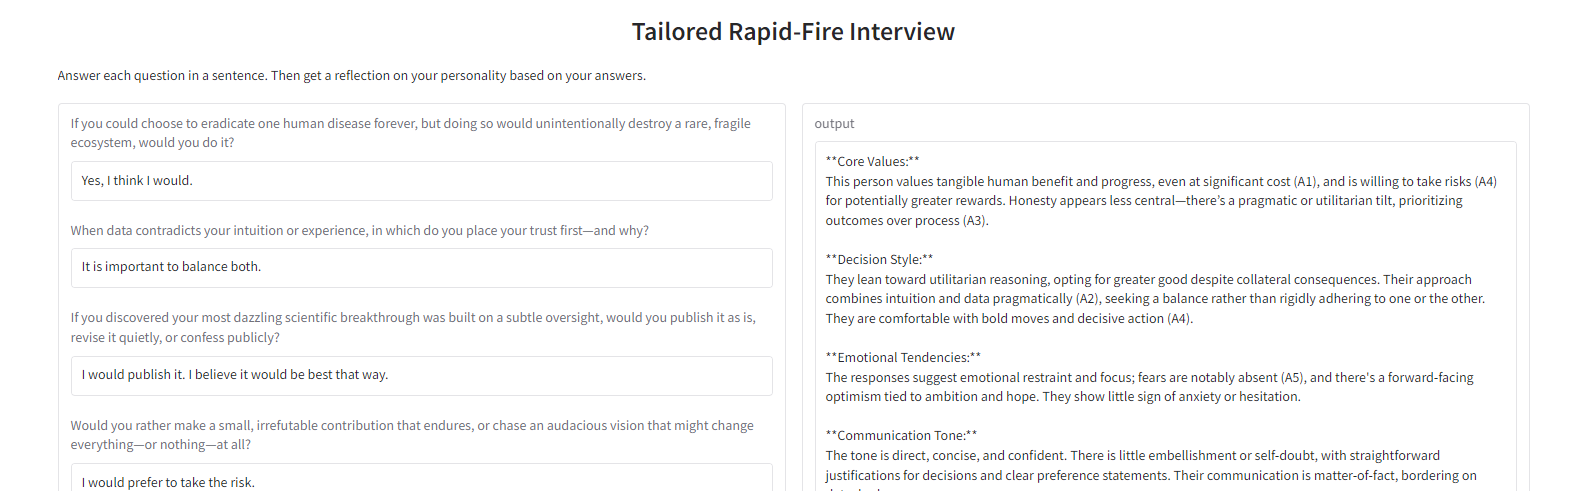

In [18]:
# Print example of interview interface
Image("interview.png")

The memory retention works well and the chatbot operates very quickly without lag issues.

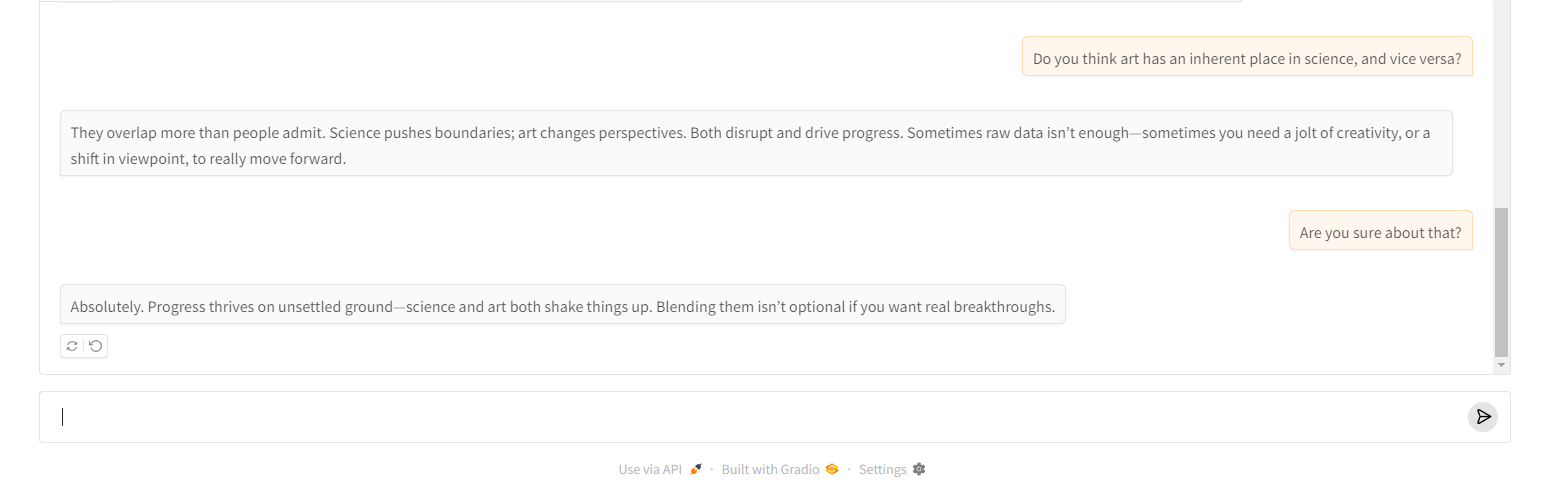

In [19]:
# Print example of AI Twin chatbot interface
Image("chatbot.png")

Funnily enough, based on the results of the reverse Turing Test, the zero-shot classifier seems to think I am AI. I chose a zero-shot classifier because it would be able to assign labels it has not seen before, but it would also be feasible to use an agent instead. However, I would prefer not to use an OpenAI-based agent, which should be much more familiar with its own generated text than anything I would write myself, resulting in a potentially significant bias. I would be interested in trying this out on other people to see the results.

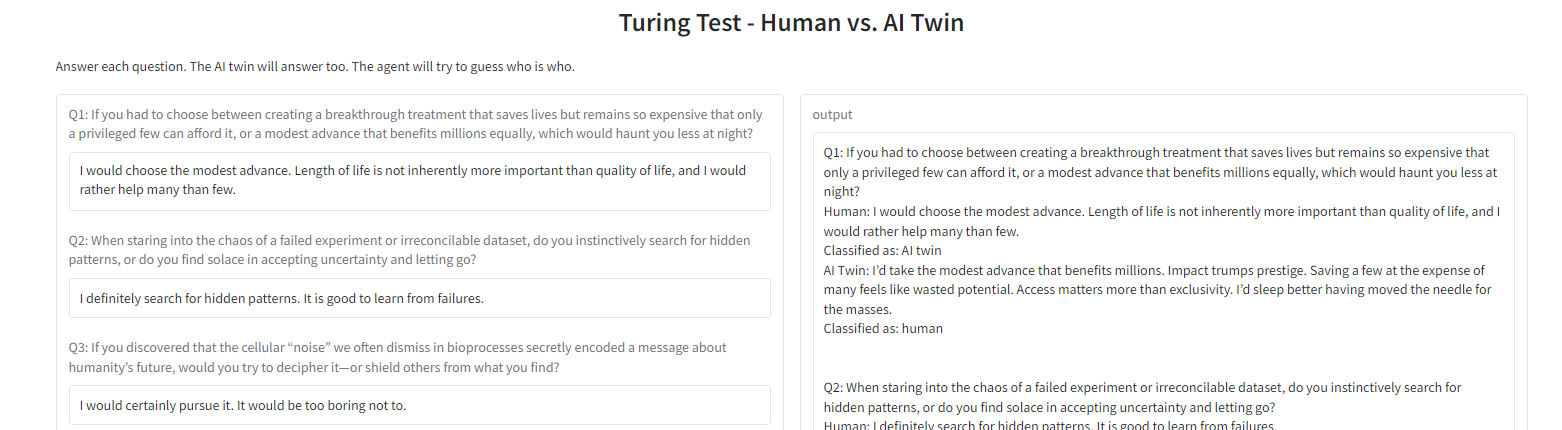

In [97]:
# Print example of Turing Test interface
Image("turing.png")

---